## Clasificación usando SVM y Bag of Words con descriptores SIFT

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-8-Clasificacion-SIFT-BoW.ipynb)

En este ejemplo se realizará la clasificación de autos usando SVM y Bag of Words (BoW) con SIFT (en este caso, BoW también se suele denominar BoF o Bag of Features). El procedimiento de entrenamiento es el siguiente:
* Se extrae descriptores SIFT de imágenes que son autos y de imágenes que no son autos

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

Los datos que se utilizará son el dataset llamado CarData (los datos originales provienen de [aquí](https://cogcomp.seas.upenn.edu/Data/Car/).

In [3]:
!wget -q https://github.com/gcr/arc-evaluator/raw/master/CarData.tar.gz
!tar -xf CarData.tar.gz

## 1.&nbsp;Creación de BoW

### 1.1. Centroides usando K-means

Se inicializa dos instancias:
* `sift`: se utiliza para extraer puntos de interés (características o "features") de la imágen y crear descriptores de dichos puntos.
* `cv2.BOWKMeansTrainer`: se utiliza para clusterizar los descriptores (SIFT, en este caso) en $k$ clusteres, utilizando el algoritmo "k-means". Se toma descriptores de entrada (cada uno de tamaño 128, por ser SIFT), se clusterizan, y se representan utilizando los centroides de los clusteres obtenidos. Estos centroides (cada uno de tamaño 128, por ser SIFT) serán utilizados como el vocabulario de BoW (Bag of Words)

In [2]:
# Instancia del descriptor SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Objeto para clusterizar los descriptores SIFT en Bag of Words (40 clústeres)
nclusters = 40
bow_kmeans_trainer = cv2.BOWKMeansTrainer(nclusters)

Se extrae los descriptores SIFT de $2 n_{bow}$ imágenes de muestra: $n_{bow}$ imágenes positivas y $n_{bow}$ imágenes negativas. Notar que se obtendrá varios descriptores de cada imagen. Cada uno de estos descriptores se añade al objeto `bow_kmeans_trainer`, el cual al llamar a su método `cluster` genera clústeres de estos descriptores. Estos clústeres luego se representan por su respectivo centroide. Los centroides constituyen el vocabulario de BoW.

In [3]:
n_bow = 10

# Creación de detectores SIFT y añadirlos a BoW
for i in range(n_bow):
    # Lectura de la imagen positiva y negativa
    Ipos = cv2.imread('CarData/TrainImages/pos-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    Ineg = cv2.imread('CarData/TrainImages/neg-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    # Extracción de descriptores SIFT
    keypoints_pos, descriptores_pos = sift.detectAndCompute(Ipos, None)
    keypoints_neg, descriptores_neg = sift.detectAndCompute(Ineg, None)
    # Añadir descriptores al entrenador de vocabulario de BoW
    if descriptores_pos is not None:
        bow_kmeans_trainer.add(descriptores_pos)
    if descriptores_neg is not None:
        bow_kmeans_trainer.add(descriptores_neg)

# Clusterización de los detectores SIFT usando K-means. Retorna los centroides de cada cluster.
bow_centroids = bow_kmeans_trainer.cluster()

In [4]:
print("(número centroides, atributos por centroide):", bow_centroids.data.shape)

(número centroides, atributos por centroide): (40, 128)


### 1.2. Histogramas de BoW

Se inicializa dos objetos:

* `FLANN` (Fast Library for Appropriate Nearest Neighbors): se utilizará para asociar cada nuevo descriptor SIFT a una palabra (centroide de SIFT) de BoW con el objetivo de poder crear un histograma.

* `cv2.BOWImgDescriptorExtractor`: implementa BoW propiamente dicho, ya que se utiliza para crear los descriptores BoW respresentados mediante un histograma del vocabulario obtenido (centroides de SIFT). Cada histograma representa la frecuencia de ocurrencia de las palabras visuales en la imagen.

In [5]:
# FLANN para encontrar las correspondencias
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = {}
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Objeto de histogramas BoW que utilizará SIFT y FLANN
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

Utilizando el método `setVocabulary` se asigna los centroides previamente calculados como vocabulario de Bag of Words.

In [6]:
# Generación del vocabulario usando los centroides
bow_extractor.setVocabulary(bow_centroids)

# Número de elementos de "box_extractor": 40 clústeres (cada uno con un vector SIFT de 128 elementos)
print("Número de elementos del histograma:", bow_extractor.getVocabulary().shape[0])
print("Tamaño del descriptor (SIFT) de cada elemento:", bow_extractor.getVocabulary().shape[1])

Número de elementos del histograma: 40
Tamaño del descriptor (SIFT) de cada elemento: 128


**Creación del conjunto de entrenamiento**

El conjunto de entrenamiento utilizará una cierta cantidad de imágenes positivas y negativas. Para cada imagen se realiza lo siguiente:
* Se calcula sus descriptores SIFT, de tamaño 128 cada uno, pero con cantidad variable de descriptores.
* Cada uno de estos descriptores SIFT se asocia ("match") a una de las $k$ palabras visuales, que son los centroides (de SIFT) obtenidos previamente.
* Con estas asociaciones se construye un histograma de tamaño $k$ contando la frecuencia de ocurrencia (correspondencia) de cada centroide. Estos dos últimos pasos se realizan con el método `compute` de `BOWImgDescriptorExtractor`.
* El histograma se añade al conjunto de entrenamiento junto con una etiqueta que indica si es un auto (1) o si no lo es (-1).

In [7]:
# Número de elementos en el conjunto de entrenamiento de imagenes positivas y negativas
n_training = 450

training_data = []
training_labels = []

# Extracción de descriptores BoW
for i in range(n_training):
    # Para imágenes positivas (autos)
    pos_img = cv2.imread('CarData/TrainImages/pos-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    features = sift.detect(pos_img)
    # Histograma BoW utilizando el vocabulario visual previamente obtenido
    pos_descriptors = bow_extractor.compute(pos_img, features)
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)

    # Para imágenes negativas (no autos)
    neg_img = cv2.imread('CarData/TrainImages/neg-%d.pgm'%(i+1), cv2.IMREAD_GRAYSCALE)
    features = sift.detect(neg_img)
    # Histograma BoW utilizando el vocabulario visual previamente obtenido
    neg_descriptors = bow_extractor.compute(neg_img, features)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(0)

In [8]:
# Conversión de los datos de entrenamiento de lista a arreglos de Numpy
Xtrain = np.array(training_data)
ytrain = np.array(training_labels)

print("Tamaño del conjunto de entrenamiento:", Xtrain.shape)
print("Cantidad de instancias de entrenamiento:" , Xtrain.shape[0])
print("Tamaño de cada vector de entrenamiento (histograma BoW):",  Xtrain.shape[1])

Tamaño del conjunto de entrenamiento: (899, 40)
Cantidad de instancias de entrenamiento: 899
Tamaño de cada vector de entrenamiento (histograma BoW): 40


## 2.&nbsp;Entrenamiento del clasificador

En este ejemplo se utilizará un SVM como clasificador para identificar si se trata de un auto o no. La entrada al SVM son los histogramas de BoW, que tienen un tamaño fijo.

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instancia de SVM con kernel RBF
svm = SVC(kernel='rbf')

# Entrenamiento usando el SVM
svm.fit(Xtrain, ytrain);

Se evaluará el comportamiento del clasificador SVM entrenado, en el conjunto de entrenamiento

In [10]:
# Predicciones (auto/no auto) en el conjunto de entrenamiento
ytrain_predicted = svm.predict(Xtrain)

# Exactitud en el conjunto de entrenamiento
acc_train = accuracy_score(ytrain_predicted, ytrain)

print('Exactitud en el conjunto de entrenamiento para el SVM lineal:', round(acc_train, 4))

Exactitud en el conjunto de entrenamiento para el SVM lineal: 0.9366


## 3.&nbsp;Evaluación

Para realizar la evaluación, cada nueva imagen debe pasar por los siguientes pasos, que son similares a los utilizados para generar el dataset de entrenamiento:
* Se obtiene los descriptores SIFT de la imagen
* Se obtiene el histograma de BoW utilizando estos descriptores
Es el histograma BoW el que se utiliza como entrada al clasificador para realizar la predicción.

In [11]:
import glob
list_test_img = glob.glob('CarData/TestImages/*.pgm')

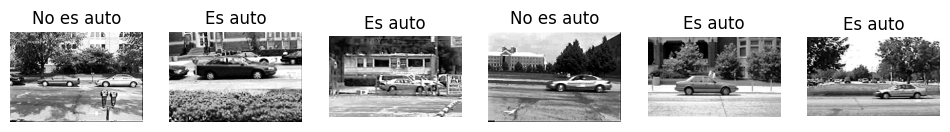

In [13]:
import random

n = 6
list_img = random.sample(list_test_img, n)

plt.subplots(1, n, figsize=(12,12))
for idx, test_img_path in enumerate(list_img):
    # Nueva imagen
    I = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    # Histogramas de BoW usando SIFT
    features = sift.detect(I)
    descriptors = bow_extractor.compute(I, features)
    # Predicción del SVM
    ypred = svm.predict(descriptors)

    # Diccionario
    label = {0:'No es auto', 1:'Es auto'}
    # Gráfico
    plt.subplot(1,n,idx+1); plt.axis('off'); plt.title(label[ypred.item()])
    plt.imshow(I, cmap='gray')

plt.show()